#**Maestría en Inteligencia Artificial Aplicada**
##**Curso: Procesamiento de Lenguaje Natural (NLP)**
###Tecnológico de Monterrey
###Prof Luis Eduardo Falcón Morales

## ** Actividad Semanas 6 y 7**

###**Modelado de tópicos - LSI/LDA**

#### **Nombres y matrículas de los integrantes del equipo:**

*   Renzo Zagni A01795457
*   Angel Iván Ahumada Arguelles A00398508
*   Karina Zafra Vallejo A01793979
*   Ernesto Zapata Garza A00915255


In [ ]:
!python -m spacy download es_dep_news_trf

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 407.8/407.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.3/236.3 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 731.6/731.6 kB 11.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-man

In [ ]:
#
# Librerias requiridas durante la actividad
import os
import re
import sys
import regex
import json
import time
import pandas as pd
import spacy
import matplotlib.pyplot as plt
import seaborn as sns
import gensim
import gensim.corpora as corpora

from time import strftime
from time import gmtime
from collections import Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from gensim.models import LdaMulticore

import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')
DIR = "/content/drive/MyDrive/Colab Notebooks/NLP"
os.chdir(DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).



**1. Descarga el archivo noticiasTopicModeling.txt que se encuentra en Canvas. Este archivo consiste en 5658 noticias de varios periódicos de España. El archivo de texto es una lista en el siguiente formato:
[{“titular”:”Encabezado“, “texto”:”Cuerpo”}, ... , {“titular”:”Encabezado”,”texto”:”Cuerpo”}]
Donde “titular” es el encabezado de la noticia y “texto” es el cuerpo del texto de dicha noticia. En particular en esta actividad trabajarás solamente con los cuerpos de las noticias, sin incluir los encabezados. Carga dicho archivo y genera un DataFrame de Pandas llamado “df” y que contiene una única columna llamada “noticia” con 5658 renglones formados por los cuerpos de las noticias.**

In [ ]:
#
# Cargamos el archive de noticias
archivo_noticias = 'noticiasTopicModeling.txt'
contenido = ''
with open(archivo_noticias, "r", encoding="utf-8") as file:
    contenido = json.load(file)


In [ ]:
# Validamos que tengamos el numero correcto de filas
assert len(contenido) == 5658

In [ ]:
#
# Creamos dataframe con el contenido del archivo de noticias
# Elimanamos columna titular
# Renombramos columna text a noticia
df = pd.DataFrame(contenido)
df.drop(columns=['titular'], inplace=True)
df.rename(columns={'texto':'noticia'}, inplace=True)

**2. Realiza un proceso de limpieza. Aplica el preprocesamiento que consideres adecuado para texto en español. Recuerda que el objetivo es identificar los tokens (palabras) que describan mejor la distribución de cada tema.
NOTA: Recuerda que esta es una técnica no supervisada, por lo que no requerimos hacer una partición de los datos.**


In [ ]:
#
# Asegurarnos que la libreria spacy tenga acceso a los GPU
spacy.require_gpu()
nlp = spacy.load("es_dep_news_trf")

stop_words = spacy.lang.es.stop_words.STOP_WORDS

def limpieza_tokens(linea):

    # Eliminamos caracteres no alfabeticos
    wds = regex.sub(r'[^\p{Letter}\s]', '', linea)
    #
    # Eliminamos tokens de longitud igual o menor que 2
    wds = re.sub(r'\b\w{1,2}\b', '', wds)
    #
    # Eliminamos espacios en blanco duplicados
    wds =  re.sub(r'\s+', ' ', wds).strip()
    #
    # Covertimos la palabras a minusculas
    wds = wds.lower()
    #
    # Eliminamos stop words
    wds = ' '.join([word for word in wds.split() if word not in stop_words])
    #
    # Aplicamos tecnica de lemmatizacion utilizando libreria spacy
    tokens = [wd.lemma_ for wd in nlp(wds)]

    return tokens

starttime = time.time()

for idx, row in df.iterrows():
  df.at[idx,'noticia'] = limpieza_tokens(row['noticia'])
  if (idx + 1) % 10 == 0:
    sys.stdout.write("\rNumero de renglones procesados: " + str(idx + 1))
    sys.stdout.flush()
sys.stdout.write("\rNumero de renglones procesados: " + str(idx + 1))

endtime = time.time()

print(strftime("\nTiempo de Ejecuccion: %M min %S sec", gmtime(endtime - starttime)))

Numero de renglones procesados: 5658
Tiempo de Ejecuccion: 06 min 44 sec


In [ ]:
# Validamos que tengamos el numero correcto de filas
assert df.shape[0] == 5658

In [ ]:
# Guardamos el dataframe para procesamientos futuros
filename = 'lsi_lda_df.csv'
df.to_csv(filename, encoding='utf-8', index=False)

# Parte 1: Indexación semántica latente (LSI):
**3. Encontrar la matriz Tf-idf de la columna de noticias. Despliega los primeros 5 renglones con algunas de sus columnas con sus nombres, donde las columnas son los tokens. ¿Cuál es el significado de cada renglón? ¿Y el significado de cada columna?**

# **Respuestas:**

**¿Cuál es el significado de cada renglón?**

Cada renglón de la matriz Tf-idf representa un documento del corpus original. En este caso, cada documento es una noticia. Como tenemos 5658 documentos, la matrix Tf-idf tendra 5658 filas o renglones

**¿Y el significado de cada columna?**

Cada columna de la matriz Tf-idf representa un token o palabra de nuestro diccionario. Como nuestro diccionario (como se muestra el las siguientes celdas) tiene 78563 palabras, nuestra matrix Tf-idf constara de 78563 columnas

**Nota:**

Cada elemento en la matrix representa la importancia, significancia o el peso de cada palabra en el documento, lo que nos permite darnos una idea de lo que se pueda estar hablando en cada uno, por ejemplo, en la primera noticia se resaltan los siguientes términos (en los 30 de 78563 que decidimos mostrar)
Vox: 0.247961; Extrema: 0.155276; España: 0.136330; Europa: 0.116636; Metáfora: 0.118795  
Sin embargo, esta es una primera aproximación, ya que dentro de un documento pueden existir varios subtemas, y eso se analizará más adelante.

In [ ]:
#
# Creamos nuestro diccionario
diccionario = Counter()

for k in range(df.shape[0]):
  diccionario.update(df['noticia'][k])

In [ ]:
print("Longitud del diccionario:", len(diccionario))
print('\n10 Palabras mas comunes):')
diccionario.most_common(10)

Longitud del diccionario: 78563

10 Palabras mas comunes):


[('año', 10806),
 ('gobierno', 10374),
 ('caso', 10202),
 ('persona', 8456),
 ('coronavirus', 6766),
 ('madrid', 6147),
 ('españa', 5995),
 ('país', 5411),
 ('público', 5234),
 ('poder', 5105)]

In [ ]:
#
# Generamos nuestro vocabulario
vocabulario = list(diccionario.keys())

#
# Convertimos lista de palabras a string
noticias = []
for idx in range(df.shape[0]):
  noticias.append(' '.join(df['noticia'][idx]))

In [ ]:
print("Numero de tokens en el vocabulario: {} ".format(len(vocabulario)))

Numero de tokens en el vocabulario: 78563 


In [ ]:
#
# Generamos matrix Tf-idf
#
tfidfvectorizer = TfidfVectorizer(vocabulary=vocabulario, max_df=0.2)
tfid_noticias = tfidfvectorizer.fit_transform(noticias)
tfidf_tokens = tfidfvectorizer.get_feature_names_out()

noticias_df = pd.DataFrame(data = tfid_noticias.toarray(),  columns = tfidf_tokens)

endtime = time.time()


In [ ]:
noticias_df.shape

(5658, 78563)

In [ ]:
print("Algunas columnas de los primeros cinco renglones:")
print("------------------------------------------------\n")
print(noticias_df.iloc[:5,0:30].to_string()+ "\n")

Algunas columnas de los primeros cinco renglones:
------------------------------------------------

     españa   dejado  católica     decir    manuel     azaña  comienzo  república  congreso  diputados   aprobar     leyes  laicista  metáfora  católico     papel       ley  creencias    pueblo  migración  integración   europea  programa       vox    europa   domingo  noviembre  excepción  potencia   extrema
0  0.136330  0.09855   0.05965  0.027968  0.065981  0.073231   0.04119   0.042993  0.030471   0.040491  0.032798  0.057578  0.085246  0.118795  0.054400  0.030227  0.081797   0.082375  0.034895   0.048518     0.051416  0.070312  0.033151  0.247961  0.116636  0.033995   0.035178   0.079745  0.051305  0.155276
1  0.009309  0.00000   0.00000  0.000000  0.000000  0.000000   0.00000   0.000000  0.000000   0.000000  0.000000  0.000000  0.000000  0.000000  0.026003  0.000000  0.000000   0.000000  0.000000   0.000000     0.000000  0.000000  0.000000  0.304779  0.000000  0.000000   0.000000  

**4. Aplica el método de descomposición de valores singulares truncado a la matriz Tf-idf anterior con 10 componentes y obtener el gráfico de la importancia relativa de estas.**

In [ ]:
# Numero de componentes a obtener
num_svd = 10

obj_svd = TruncatedSVD(n_components = num_svd,
                       n_iter = 100,
                       random_state = 1)

tfidf_svd = obj_svd.fit_transform(tfid_noticias)

Sigma = obj_svd.singular_values_
V_T = obj_svd.components_.T

In [ ]:
Sigma

array([14.02470406,  7.69386023,  6.13282294,  5.95940164,  5.86101154,
        5.73142372,  5.38933748,  5.13757862,  4.86822599,  4.85984885])

In [ ]:
V_T.shape

(78563, 10)

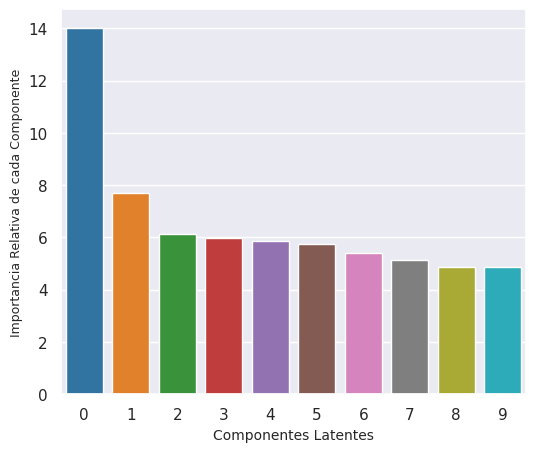

In [ ]:
sns.set(rc={'figure.figsize':(6,5)})
sns.color_palette("tab10")
chart = sns.barplot(x=list(range(len(Sigma))), y = Sigma, palette="tab10")
chart.set_xlabel('Componentes Latentes', fontdict={'size': 10})
chart.set_ylabel('Importancia Relativa de cada Componente', fontdict={'size': 9})
plt.show()

**5. Obtener la matriz tokens-temas (term-topic) a partir de la matriz 𝑉t de la descomposición SVD. Despliega sus primeros 5 renglones donde se incluya el nombre de las columnas.**

In [ ]:
#
# Generamos data frame con la matrix term topic
term_topic_matrix = pd.DataFrame(data=V_T,
                                 index = list(tfidfvectorizer.get_feature_names_out()),
                                 columns = [f'Concepto_Latente_{r}' for r in range(0,V_T.shape[1])]
                                )


In [ ]:
print(term_topic_matrix.shape)

(78563, 10)


In [ ]:
#
# Desplegamos los 5 primeros renglones
term_topic_matrix.head(5)

,Concepto_Latente_0,Concepto_Latente_1,Concepto_Latente_2,Concepto_Latente_3,Concepto_Latente_4,Concepto_Latente_5,Concepto_Latente_6,Concepto_Latente_7,Concepto_Latente_8,Concepto_Latente_9
españa,0.091055,0.009367,-0.021255,-0.041047,-0.036618,0.036813,0.026818,-0.075812,0.007215,0.086308
dejado,0.017228,0.001524,0.004244,-0.011393,-0.004155,0.003043,0.005037,-0.007577,0.022585,0.005503
católica,0.001746,-0.001778,-0.002211,0.000236,-0.000245,0.001629,-0.000763,0.001145,0.000160,-0.000299
decir,0.027276,-0.022156,-0.024245,-0.005005,-0.002362,0.022057,-0.031919,-0.010243,0.030237,-0.004102
manuel,0.018818,-0.030483,0.011283,0.029375,-0.037131,-0.021431,0.002044,-0.013709,-0.012064,-0.016742


**Con base a la cantidad de conceptos latentes que determinaste en el ejercicio anterior, obtener cada uno de sus gráficos con sus 10 términos/tokens más importantes. ¿Cómo describirías cada uno de dichos conceptos latentes? ¿Se identifican claramente las temáticas de cada uno de ellos?**

# **Respuestas:**

Cada concepto latente es una combinación de las palabras del corpus donde aquellas con mayores coeficientes tienen una mayor influencia en la definición de un componente. Cuando hablamos de temáticas observamos las gráficas con sus conceptos más relevantes y podemos interpretar de que trata dicho tema, pero dicha interpretación es subjetiva y podemos observar que se hablan de temas de pandemia, políticos y sociales.

**¿Cómo describirías cada uno de dichos conceptos latentes?**

Entre el Concepto latente 0 y el 1: no es tan fácil identificar una diferencia en la temática ya que tienen términos asociados similares en ambas. El tópico podría ser la evolución del coronavirus en España, quizás principalmente en Madrid para el caso del concepto 0 y a nivel país para el 1, también puede estar hablando de estadísticas por municipios, por ejemplo cantidad de personas afectadas (positivos), como ha sido la propagación del virus y quizás las medidas que ha tomado el gobierno para el control de la pandemia.

<u>Concepto Latente 0</u>: **Salud**

Este concepto incluye el token "coronavirus" con el peso más alto lo que no sorprende ya que la pandemia influyó significativamente en los diferentes tipos de noticias a nivel mundial. Si bien este termino indica un tema de Salud, los terminos "gobierno" , "madrid", "españa", "medida" indican acciones o discusiones entre políticos para responder a la crisis por lo que el tópico podría ser Pólitica

<u>Concepto Latente 1</u>: **Salud**

Las dos palabras con más peso son "coronavirus" y "covid" y además incluye palabras como "caso", "mapa", "positivo" , "pandemia" y "evolución" lo que hace claro su definición como un tema de Salud.

<u>Concepto Latente 2</u>: **Política**

Las palabras claramente identifican este concepto como un tema de Política. Parece estar relacionado con un tema de elecciones por regiones del país como lo es Madrid y Euskadi, en el primer momento, las palabras casado y ciudadanos pueden ser confusas, pero si investigamos un poco, encontramos que casado se refiere al apellido de un político y ciudadanos al nombre de un partido. Lo que tiene sentido con Sánchez que también es el apellido de otro político y vox otro partido.

<u>Concepto Latente 3</u>: **Sucesos**

Es interesante como la palabra "Villarejo" es la mas prominente en esta concepto. Esta se refiere al caso policiaco que involucró actos de terrorismo y corrupción [1] Las otras palabras que la acompañan "caso", ""municipio", "policia" claramente identifican el tópico como Sucesos. Lo curioso es que mencione el término Osakidetza que se refiere al sistema de salud del país vasco, faltaría tener el contexto del país para entender un poco más de que se trata.

<u>Concepto Latente 4</u>: **Regionales**

Este concepto cuenta con un gran numero de palabras en Vasco:
euskadi, vasco, alava, y bizkaia: Se refieren al País Vasco
pnv, urkullu, y bildu: Se relacionan con la política vasca
osakidetza: sistema de salud vasco
No parece sencillo entender de que se trata este concepto. ¿Quizás opiniones diversas que cada uno da sobre el manejo que se le dio a la pandemia en estas regiones por estas personas?. El concepto latente podria referirse a noticias regionales, politica, o ambas.

<u>Concepto Latente 5</u>: **Salud**

Las palabras "rebrote" y "covid" a nuestro parecer son una indicación de que el topico del concepto es Salud con Política o quizás mostrando gráficos de como ha evolucionado la pandemia por provincias y como esto afectó a la población especialmente a las mujeres.

<u>Concepto Latente 6</u>: **Economía**

Las palabras "euros", "empresas", "erte"<sup>*</sup>, "contrato", "millon"," trabajador", "empleo" son claros indicadores de que el topico de este concepto es la Economía. También podrían estar hablando de cifras sobre empleo quizás asociado a la época de la pandemia ya que mencionan ERTE, es decir, pueden estar mencionando como fueron las medidas que tomaron las empresas frente a las decisiones del gobierno, por ejemplo, cambios en los contratos y como afectaba esto a las empresas y a los trabajadores.

<sup>*</sup>*erte: expedientes de regulación temporal de empleo*

<u>Concepto Latente 7</u>: **Educación**

Las palabras "master", "alumno", "educacion", "curso", "clase", "aula", "universias son claros indicadores de que el topico de este concepto es la Educación. Sin embargo, llama la atención que se tengan las palabras Cifuentes y Casado, quizás relacionadas con los temas anteriores, en donde pueden ser apellidos de personajes políticos de España.

<u>Concepto Latente 8</u>: **Politíca**

Aunque menos claro que en los conceptos anteriores, las palabras "madrid", "ayuso"<sup>**</sup> , "presidente", "pnv", "comunidad" nos indican que el topico es la politíca, aunque las palabras como "mujer", "coronavirus", "regional" y "euskadi" podrian estar indicando otros topicos o subtópicos. Puede estar haciendo referencia a la Sra Ayuso, presidenta de la comunidad de Madrid y quizás como fue el manejo que le dio a la situación durante el coronavirus. También se menciona Euskadi (país vasco), quizás están haciendo alguna comparativa regional y como fue el papel de las mujeres políticas durante esta crisis.

<sup>*</sup>*ayuso: Isabel Diaz Ayuso. Diputada de la Asamblea de Madrid*

<u>Concepto Latente 9</u>: **Inderteminado**

Este concepto cuenta con una mezcla de palabra que hace difícil determinar el topico principal. Si bien las palabras "rey", "juan" y "carlos" pueden ser referencia a la monarquia española, las palabras "casado", "cifuentes", y "álvarez" hacen referencia a figuras públicas políticas, las palabras "universidad" y "asignatura"  apuntan hacia Educación , mientras que la palabra "Coronavirus" nos apunta a temas de Salud. Podría estar hablando de algunas opiniones que dieron estos personajes frente a la educación frente a la época del coronavirus.

**¿Se identifican claramente las temáticas de cada uno de ellos?**

En el caso de los primeros ocho conceptos latentes, del 0 al 7; si se puede identificar claramente las tematicas de cada uno de ellos. Es en el concepto latente ocho donde se empieza a hacer in poco más difícil identificar claramente la temática y es en el concepto nueve donde se hace muy difícil determinar si el tema es de la Sociedad Española, de Educación o de Salud por lo que decidimos dejarlo como indeterminado.

---  

<font size="-1">Referencias:
Wikipedia contributors. (2024, marzo 4). *José Manuel Villarejo*. Wikipedia. https://en.wikipedia.org/wiki/Jos%C3%A9_Manuel_Villarejo</font>

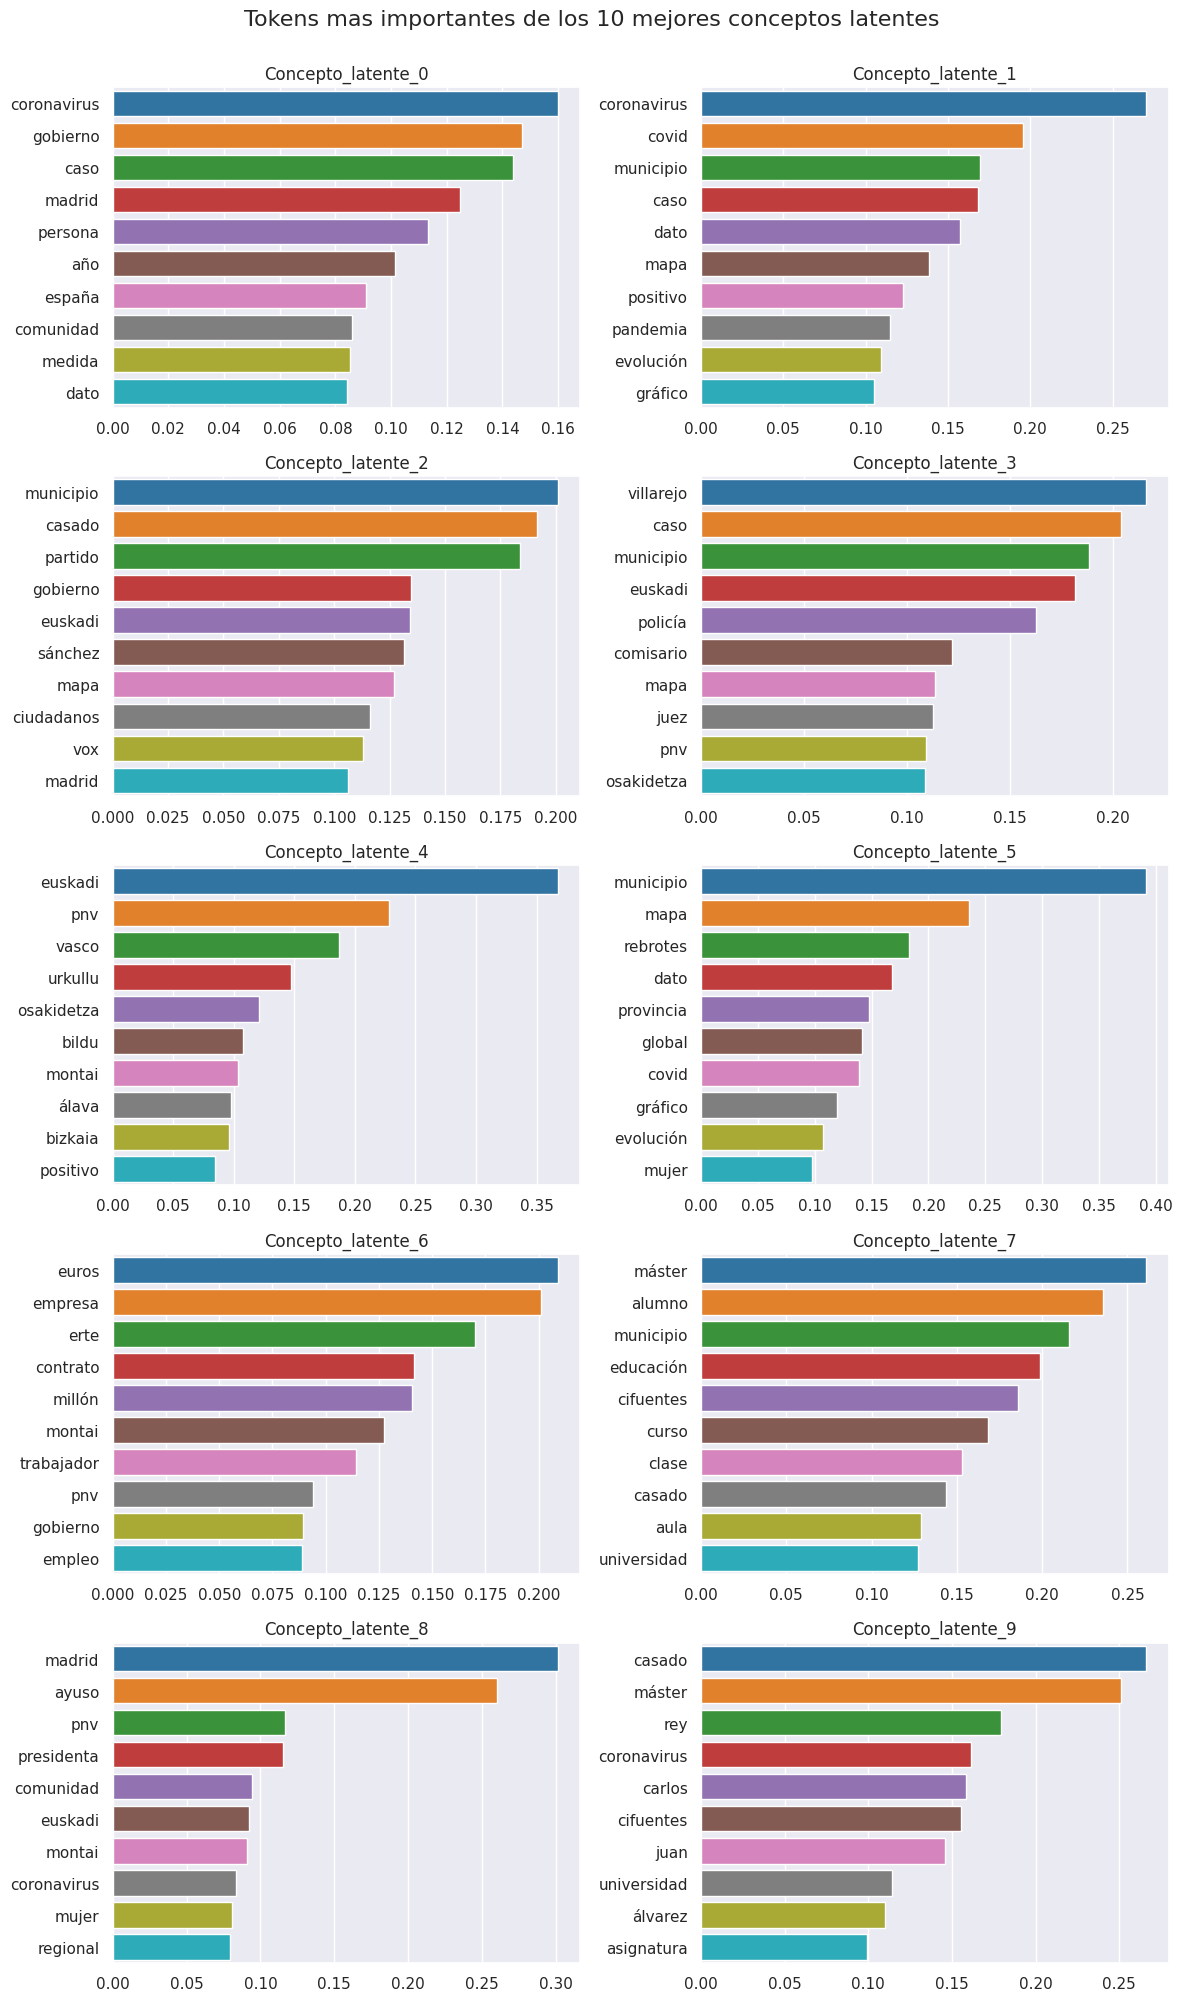

In [ ]:
top_tokens = 10

fig, axes = plt.subplots(figsize=(12,20))
fig.suptitle("Tokens mas importantes de los 10 mejores conceptos latentes", fontsize=16, y=1)
col_cnt = 1
for colname in term_topic_matrix.columns:
  data = term_topic_matrix[colname].sort_values(ascending=False)
  ax = plt.subplot(5,2, col_cnt)
  ax.set_title(colname.capitalize())
  bp = sns.barplot(x=data[:top_tokens].values, y=data[:top_tokens].index , palette="tab10")
  # Decluttering
  bp.set(xlabel=None, ylabel=None)
  col_cnt += 1

plt.tight_layout()

# Parte 2: Asignación de Dirichlet Latente (LDA):
**7. Utiliza la librería Gensim para implementar ahora la técnica de LDA. Revisa la documentación correspondiente y aplica de preferencia el modelo paralelizable: https://radimrehurek.com/gensim/models/ldamodel.html https://radimrehurek.com/gensim/models/ldamulticore.html**


In [ ]:
id2word = corpora.Dictionary(df['noticia'])
corpus = [id2word.doc2bow(doc) for doc in df['noticia']]

In [ ]:
#
# Modelo LDA paralelizable con numero de workers por defecto (todos los CPU cores disponibles)
# Calculamos 16 topicos latentes
starttime = time.time()

lda_model = LdaMulticore(corpus = corpus,
                         id2word = id2word,
                         num_topics = 16,
                         chunksize = 1000,
                         passes = 20,
                         iterations = 400,
                         eta = 'auto',
                         eval_every = None,
                         random_state=42)

endtime = time.time()

print(strftime("Tiempo de Ejecuccion: %M min %S sec", gmtime(endtime - starttime)))

Tiempo de Ejecuccion: 05 min 33 sec


In [ ]:
lda_model.print_topics(num_topics=16, num_words=10)

[(0,
  '0.012*"gobierno" + 0.009*"social" + 0.008*"trabajo" + 0.007*"medida" + 0.006*"trabajador" + 0.006*"empresa" + 0.005*"público" + 0.005*"laboral" + 0.005*"ley" + 0.005*"situación"'),
 (1,
  '0.016*"millón" + 0.010*"país" + 0.010*"año" + 0.010*"españa" + 0.009*"empresa" + 0.007*"euros" + 0.007*"economía" + 0.006*"europeo" + 0.006*"europea" + 0.005*"económico"'),
 (2,
  '0.020*"coronavirus" + 0.011*"persona" + 0.008*"pandemia" + 0.008*"salud" + 0.007*"caso" + 0.007*"madrid" + 0.007*"medida" + 0.007*"comunidad" + 0.007*"centro" + 0.006*"covid"'),
 (3,
  '0.012*"tribunal" + 0.010*"caso" + 0.009*"delito" + 0.009*"judicial" + 0.008*"civil" + 0.008*"juez" + 0.008*"policía" + 0.007*"guardia" + 0.007*"justicia" + 0.007*"sentencia"'),
 (4,
  '0.009*"historia" + 0.007*"película" + 0.006*"cine" + 0.006*"año" + 0.006*"obra" + 0.006*"libro" + 0.006*"guerra" + 0.005*"cultura" + 0.004*"personaje" + 0.004*"autor"'),
 (5,
  '0.024*"educación" + 0.017*"centro" + 0.016*"miguel" + 0.014*"alumno" + 0.

**8. Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada? Compara tus
resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias? ¿Cuál consideras
puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a
considerar?**

El número de tópicos óptimo es aquel que maximiza la coherencia de temas, evaluamos las gráficas para determinar en que iteración se encuentra maximizada la métrica y seleccionamos y entrenamos el modelo con ella. La coherencia se puede aplicar a ambos modelos LSI y LDA para determinar el mejor resultado.

Basado en la técnica LDA podemos determinar con relativa facilidad los temas  de los primeros 16 tópicos, como se muestra a continuación

1.  Política
2.  Economía
3.  Salud
4.  Sucesos
5.  Vida y Cultura
6.  Educación
7.  Regionales
8.  Sucesos
9.  Política
10. Internacional
11. Política
12. Política
13. Salud
14. Política
15. Sucesos
16. Vida y Cultura


**Con base a esta técnica ¿qué cantidad de tópicos consideras que es la más adecuada?**

La cantidad de topicos selectionada: 10 es adecuada para identificar cada uno de los temas. A partir del noveno topico latente no encontramos temáticas nuevas a menos que intenemos generar sub temas a partir de los temas principales.
Aplicando el método LDA, se puede observar que los términos asociados a cada tema hacen que estos sean más diferenciables entre ellos, es decir, parece que cada tema es diferente, cosa que no parecía en LSI.

**Compara tus resultados con el método LSI. ¿Qué encuentras de coincidencias y diferencias?**


```
        Comparacion de los 10 topicos mas relevantes entre LSI y LDA:

                        LSI                LDA
                 ------------------ ----------------------
1.                    Salud               Politica
2.                    Salud               Economia
3.                  Politica               Salud
4.                   Sucesos              Sucesos
5.                  Regionales          Vida y Cultura
6.                    Salud               Educacion
7.                  Economia             Regionales
8.                  Educacion             Sucesos
9.                  Politica            Internacional
10.               Indeterminado           Politica
```
El metodo LSI es eficaz para detectar patrones y relaciones entre los datos de el corpus, pero como pudimos observar esta va perdiendo signicado a medida que se incrementan el numero de componentes.

El metodo LDA nos permite identificar más claramente los temas de cada tópico y como observamos, los tópicos no perdieron significado a medida que el numero de tópicos aumentaba

**¿Cuál consideras puede ser el mejor resultado, es decir, cuál consideras puede ser la mejor cantidad de tópicos a considerar?**

Considermos que la técnica LDA con 10 topicos es la que nos da mejor resultado, ya que por un lado, nos permite identificar claramente la temática del tópico y al introducir más tópicos las tematicas son repetitivas sin ninguna clara indicación de incluir temas adicionales o subtemas que los diferencien de otros conceptos. Por otro lado, sería interesante, darle una segunda pasada a los documentos agrupados por tópicos para intentar dividirlos en sub-tópicos y poder encontrar mejores categorizaciones.


**9. Incluye tus conclusiones finales de la actividad.**


Podemos observar que ambos modelos buscan descubrir temas latentes en el corpus y se pueden seleccionar parámetros como el número de temas dependiendo de la coherencia en ambos.

Ambas técnicas tuvieron un buen desempeño al momento de identificar las temáticas de los 8 conceptos o tópicos latentes más relevantes del corpus.

Si bien LSI es más simple y rápido, puede experimentar problemas de interpretabilidad y sensibilidad al ruido a medida que aumenta el número de conceptos. En nuestro ejercicio pudimos observar este fenomeno a partir del concepto latente número 8. LSI puede ser más adecuado para capturar relaciones.

El metodo LDA proporciona tópicos más claros y no es tan sensible al numero de conceptos o tópicos como lo es el metodo LSI, lo que nos permitió la interpretación de tópicos más allá de los 8 más relevantes. LDA está basada en modelos de Dirichlet la cual nos puede ayudar mejor en capturar la distribución de palabras en temas específicos. Aunque LDA es mejor para manejar para manejar grandes volúmenes de datos esto se traduce directamente en mayor complejidad y tiempo de cálculo.

